In [2]:
pip install --upgrade fastai

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install fastai

In [4]:
from fastai.vision.all import *

In [5]:
import os
import pandas as pd
import numpy as np

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.vision import *
#from fastai.callback.cutmix import *

In [8]:
%reload_ext autoreload

In [62]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/train'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = DATA_DIR + '/train.csv'   

In [10]:
train_df = pd.read_csv(TRAIN_CSV)
train_df['imgPath'] = train_df.apply(lambda x : os.path.join(TRAIN_DIR,str(x['Image'])+'.png'),axis=1)
train_df.head()

,Image,Label,imgPath
0,19567,9,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png
1,29993,6 4,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png
2,17186,1 4,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png
3,29600,6 2,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png
4,701,3 4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png


In [11]:
split_df = pd.get_dummies(train_df.Label.str.split(" ").explode())
split_df = split_df.groupby(split_df.index).sum()
split_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,1,0,0,0
2,0,1,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0
4,0,0,0,1,1,0,0,0,0,0


In [12]:
X, y = split_df.index.values, split_df.values

In [13]:
from skmultilearn.model_selection import IterativeStratification

nfolds = 5

k_fold = IterativeStratification(n_splits=nfolds, order=1)

splits = list(k_fold.split(X, y))

fold_splits = np.zeros(train_df.shape[0]).astype(int)

for i in range(nfolds):
    fold_splits[splits[i][1]] = i

In [14]:
train_df['Split'] = fold_splits

In [15]:
def get_fold(fold):
    train_df['is_valid'] = False
    train_df.loc[train_df.Split == fold, 'is_valid'] = True
    return train_df


In [16]:
train_df.head()

,Image,Label,imgPath,Split
0,19567,9,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,0
1,29993,6 4,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,4
2,17186,1 4,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,0
3,29600,6 2,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,1
4,701,3 4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,2


In [17]:
train_df = get_fold(0)
train_df = train_df.drop(['Split'],axis=1)
train_df.head()

,Image,Label,imgPath,is_valid
0,19567,9,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png,True
1,29993,6 4,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png,False
2,17186,1 4,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png,True
3,29600,6 2,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png,False
4,701,3 4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png,False


In [18]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [19]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [20]:
aug_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=10.0, 
               max_zoom=1.1, 
               max_lighting=0.5, 
               max_warp=0.2, 
               p_affine=0.75, 
               p_lighting=0.75, 
               xtra_tfms=RandomErasing(p=1., max_count=6), 
               size=224, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
                          0
               batch=False, 
               min_scale=0.75)

In [21]:
def get_x(r): return r['imgPath']
def get_y(r): return r['Label'].split(' ')
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

In [22]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter, 
                   get_x = get_x, get_y = get_y,
                   item_tfms=Resize(460),
                   batch_tfms=aug_tfms)

In [23]:
dls = dblock.dataloaders(train_df)

In [24]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [1]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [28]:
cutmix = CutMix(1.0)
learn = cnn_learner(dls, resnet18, 
                    metrics=[partial(accuracy_multi, thresh=0.2),partial(F_score, threshold=0.2)],
                    cbs=cutmix)

# Add EarlyStoppingCallback
learn.add_cb(EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s] 


In [31]:
# Begin training loop
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.407852,0.337595,0.814407,0.284361,02:58


In [32]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.390195,0.336665,0.796204,0.335232,02:58
1,0.369456,0.339489,0.807927,0.286406,02:59


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.355080,0.310715,0.825355,0.361106,02:59
1,0.338452,0.288980,0.846269,0.429006,03:00
2,0.334916,0.283547,0.847921,0.438278,03:02


In [34]:
# Add MixUp augmentation to your DataLoaders
mixup = MixUp(0.4)

# Create your Learner with cnn_learner
learn = cnn_learner(dls, resnet18, 
                    metrics=[partial(accuracy_multi, thresh=0.2), partial(F_score, threshold=0.2)])

# Add EarlyStoppingCallback to the Learner
learn.add_cb(EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3))

In [37]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.593215,0.360927,0.743532,0.266841,02:58
1,0.371075,0.336644,0.805732,0.314141,02:58


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.331451,0.305803,0.826749,0.426381,03:01
1,0.307488,0.284876,0.845959,0.453833,03:00
2,0.288385,0.276477,0.854144,0.473715,03:02


In [38]:
learn = cnn_learner(dls, resnet18, 
                    metrics=[partial(accuracy_multi, thresh=0.2),partial(F_score, threshold=0.2)])

# Add EarlyStoppingCallback to the Learner
learn.add_cb(EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3))

In [39]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.781062,0.552091,0.290343,0.355944,02:47
1,0.407776,0.343600,0.824787,0.229197,02:57
2,0.359872,0.334663,0.813194,0.280560,02:58
3,0.343976,0.320944,0.826982,0.329259,02:56


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.316679,0.306277,0.838781,0.439611,02:59
1,0.296270,0.281838,0.851743,0.506761,02:59
2,0.287632,0.273166,0.855771,0.507076,03:01


In [40]:
preds,targs = learn.get_preds()

In [41]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
fscores = [F_score(preds, targs, threshold=i, beta=1) for i in xs]

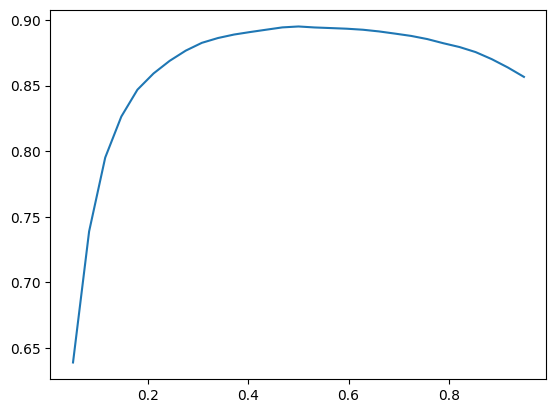

In [42]:
plt.plot(xs,accs)

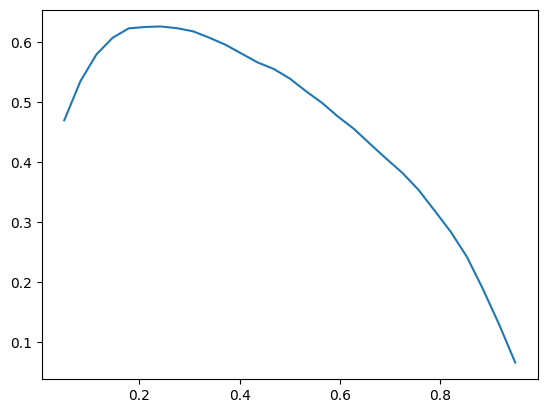

In [43]:
plt.plot(xs,fscores)

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

,target,predicted,probabilities,loss
0,4,0;1;2;3;5;6;9,"tensor([0.7400, 0.5956, 0.8921, 0.5415, 0.0434, 0.7946, 0.6272, 0.4782, 0.4014,\n 0.8912])",1.4345840215682983
1,2;4,0;5;7;9,"tensor([0.7179, 0.4126, 0.1227, 0.2826, 0.0086, 0.8666, 0.3112, 0.7236, 0.4498,\n 0.5080])",1.3965837955474854
2,0;8,0;1;2;3;4;5;6;7,"tensor([0.6363, 0.6378, 0.8462, 0.6643, 0.9511, 0.8800, 0.7294, 0.6468, 0.2949,\n 0.4859])",1.3804099559783936
3,4;6,1;3;5;7;8;9,"tensor([0.2327, 0.6491, 0.4784, 0.5705, 0.0388, 0.8636, 0.2038, 0.8594, 0.6838,\n 0.6433])",1.378386378288269
4,5,0;1;2;4;6;7;8,"tensor([0.6554, 0.5413, 0.5216, 0.1862, 0.6311, 0.3113, 0.9840, 0.9445, 0.7154,\n 0.4004])",1.3746674060821533


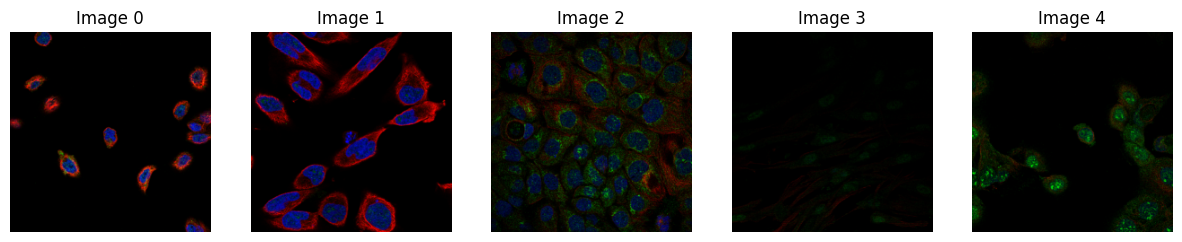

In [50]:
interp.plot_top_losses(5, nrows=1)

In [51]:
learn.export('export.pkl')

In [63]:
test_df = pd.read_csv(TRAIN_CSV)
test_df['imgPath'] = test_df.apply(lambda x : os.path.join(TEST_DIR,str(x['Image'])+'.png'),axis=1)
test_df.head()

,Image,Label,imgPath
0,19567,9,../input/jovian-pytorch-z2g/Human protein atlas/train/19567.png
1,29993,6 4,../input/jovian-pytorch-z2g/Human protein atlas/train/29993.png
2,17186,1 4,../input/jovian-pytorch-z2g/Human protein atlas/train/17186.png
3,29600,6 2,../input/jovian-pytorch-z2g/Human protein atlas/train/29600.png
4,701,3 4,../input/jovian-pytorch-z2g/Human protein atlas/train/701.png


In [64]:
dl = learn.dls.test_dl(test_df)

In [65]:
preds

tensor([[1.6753e-04, 4.9150e-02, 1.3753e-01,  ..., 7.7569e-04, 1.4245e-02,
         2.1903e-01],
        [1.5694e-02, 1.5869e-01, 8.0937e-03,  ..., 1.7000e-03, 2.5976e-02,
         2.0060e-01],
        [9.2565e-02, 2.7152e-02, 8.3788e-02,  ..., 3.6690e-01, 2.3169e-02,
         1.8459e-02],
        ...,
        [8.8703e-02, 1.0024e-01, 2.6765e-02,  ..., 8.5378e-02, 3.1056e-02,
         2.1247e-02],
        [1.4545e-02, 4.7774e-02, 1.0498e-01,  ..., 3.4420e-01, 3.2609e-02,
         2.0729e-02],
        [9.8134e-02, 2.1613e-02, 1.4767e-01,  ..., 7.2395e-01, 1.6926e-02,
         2.1540e-02]])

In [66]:
targs

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [68]:
dl = learn.dls.test_dl(test_df)

# Perform Test Time Augmentation (TTA)
preds, targs = learn.tta(dl=dl)

In [82]:
predictions = [decode_target(x, threshold=0.5) for x in preds]

In [76]:
predictions = [decode_target(x, threshold=0.2) for x in preds]

In [88]:
predictions = [decode_target(x, threshold=0.7) for x in preds]

In [89]:
submission_df = pd.read_csv(TEST_CSV)
submission_df['Pred'] = predictions
submission_df.head()

,Image,Label,Pred
0,19567,9,4
1,29993,6 4,4 6
2,17186,1 4,
3,29600,6 2,2 4 6
4,701,3 4,


In [109]:
import numpy as np

def count_matching_pairs(table):
    equal = 0
    not_equal = 0
    label = table['Label']
    pred = table['Pred']
    for label_str, pred_str in zip(label, pred):
        label_nums = set(label_str.split())
        pred_nums = set(pred_str.split())
        if any(num in pred_nums for num in label_nums):
            equal += 1
        else:
            not_equal += 1

    return equal,not_equal

equal,not_equal = count_matching_pairs(submission_df)

accuracy = equal/(not_equal + equal)

accuracy

0.7084113121231025